# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline
import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## [20 Points] Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [4]:
DATASET_PATH = os.path.abspath(".")
DATASET_NAME = "heartdisease.csv"

def load_data(dataset_path, dataset_name):
    csv_path = os.path.join(dataset_path, dataset_name)
    return pd.read_csv(csv_path)

df = load_data(DATASET_PATH, DATASET_NAME)

### Question 1.1 Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method to display some of the rows so we can visualize the types of data fields we'll be working with, then use the describe method, along with any additional methods you'd like to call to better help you understand what you're working with and what issues you might face. 

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
sick        303 non-null bool
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


In [8]:
df.isnull().count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
sick        303
dtype: int64

In [9]:
df["sex"].value_counts()

1    207
0     96
Name: sex, dtype: int64

### Question 1.2 Discuss your data preprocessing strategy. Are their any datafield types that are problemmatic and why? Will there be any null values you will have to impute and how do you intend to do so? Finally, for your numeric and categorical features, what if any, additional preprocessing steps will you take on those data elements?

A datafield type that could be problemmatic is the **sick** column because all the other datafield types are numerical while **sick** is categorical. To deal with this, we will convert this to a numerical by converting True and False to 1 and 0.
In case of augmenting features, datafield types like **cp**, **fps**, **restecg**, **exang** or any types that has 0 as a possible value can run into problem with dividing by zero. To avoid this, we might want refrain from dividing these types of datafield and find some other to augment more features or converting 0 into some other value that won't affect the result of our machine learning algorithm.

### Question 1.3  Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe.

In [10]:
df["bsick"] = df["sick"] * 1 # Because True is equivalent to 1 and False is equivalent to 0
df = df.drop("sick", axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,bsick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


### Question 1.4 Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? (Note: No need to describe each variable, but pick out a few you wish to highlight)

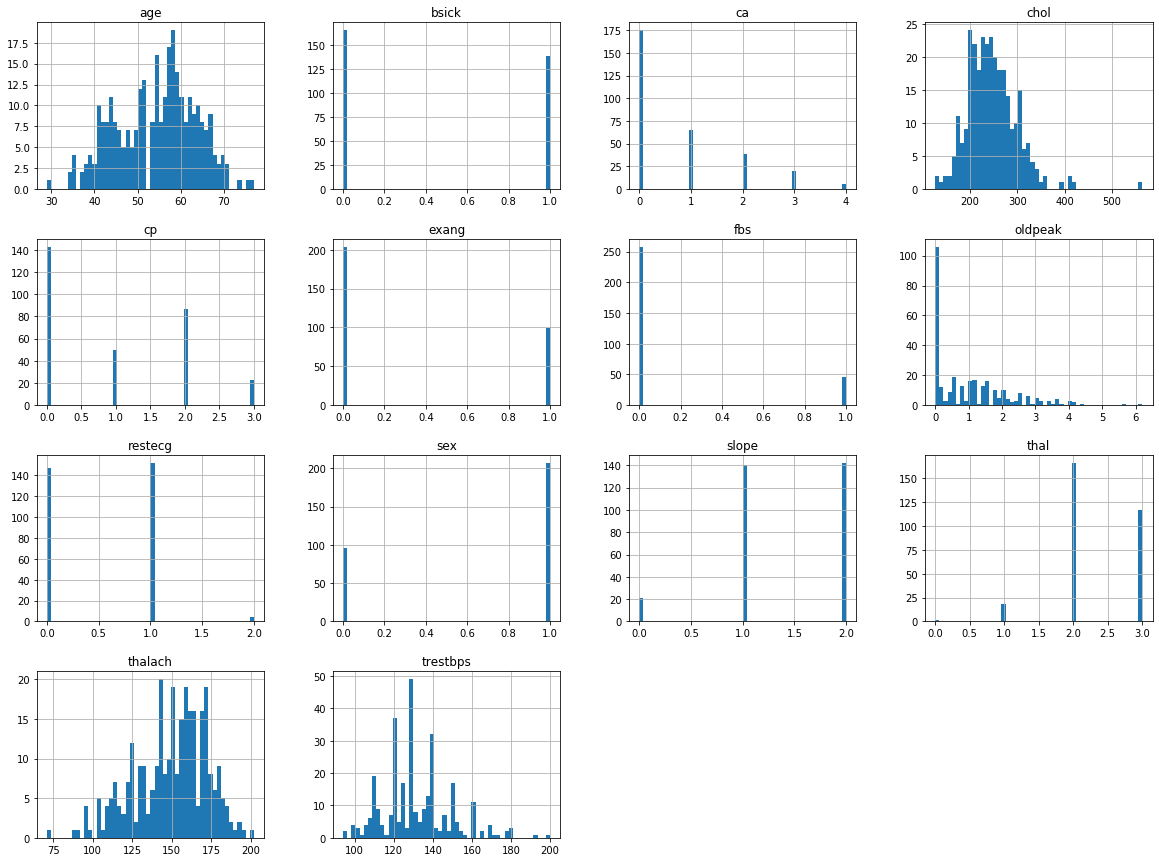

In [11]:
df.hist(bins=50, figsize=(20,15))
plt.show()

As expected, **sex** and **bsick** (binary sick) are binary features because there are only 2 possible values (**male** and **female** for **sex** and **sick** and **healthy** for **bsick**) for each feature. 
On the other hand, **age** and **chol** each follow a gradient because for **age** of a person, it can be anywhere in the range from 20 to 80; and for **chol** level, it can range from 0 to 600.

### Question 1.5 We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

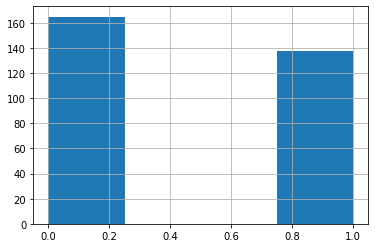

0    165
1    138
Name: bsick, dtype: int64

In [12]:
df["bsick"].hist(bins=4)
plt.show()
df["bsick"].value_counts()

There are 165 healthy individuals and 138 sick individuals. The ratio between positive and negative class is 54.5 to 45.5 which indicates that the dataset is not perfectly balanced.

### Question  1.6 Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

Some of the problems that might arise by artificially balancing a dataset:
- If we use **under-sampling**, that is, removing data randomly from the class that has more data, we might lose valuable information than could be important or useful to the model we are trying to predict. We might also introduce bias because we delete too much of one type of data.
- If we use **over-sampling**, that is, replicating instances of the class that has less data, we can increase the likelihood of overfitting since it repllicates the minority class events.

### Question 1.9 Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

In [13]:
corr_matrix = df.corr()
corr_matrix["bsick"].sort_values(ascending=False)

bsick       1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: bsick, dtype: float64

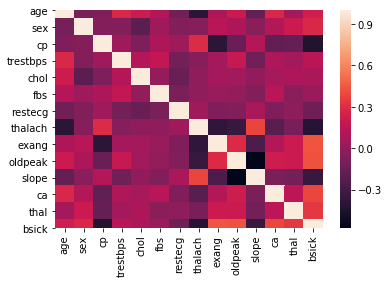

In [14]:
sns.heatmap(corr_matrix)

[Discuss correlations here] 

## [30 Points] Part 2. Prepare the Data 

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1 Save the target column as a separate array and then drop it from the dataframe. 

In [15]:
binary_sick_arr = df["bsick"]
df = df.drop("bsick", axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


### Question 2.2 First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 70% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, binary_sick_arr, test_size=0.30, random_state=42)

### Question 2.3 Now create a pipeline to conduct any additional preparation of the data you would like. Output the resulting array to ensure it was processed correctly.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = list(df)
full_pipeline = ColumnTransformer([('std_scaler', StandardScaler(), numerical_features),])

df_prepared = full_pipeline.fit_transform(df)
df_prepared

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

### Question 2.4 Now create a separate, processed training data set by dividing your processed dataframe into training and testing cohorts, using the same settings as Q2.2 (REMEMBER TO USE DIFFERENT TRAINING AND TESTING VARIABLES SO AS NOT TO OVERWRITE YOUR PREVIOUS DATA). Output the resulting shapes of your training and testing samples to confirm that your split was successful, and describe what differences there are between your two training datasets.

In [18]:
X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(df_prepared, binary_sick_arr, test_size=0.30, random_state=42)

In [19]:
X_train_processed

array([[-1.69473524, -1.46841752,  1.00257707, ...,  0.97635214,
        -0.71442887, -0.51292188],
       [-2.7976235 ,  0.68100522,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       [-0.48155814, -1.46841752,  1.00257707, ..., -0.64911323,
        -0.71442887, -0.51292188],
       ...,
       [ 1.61392956,  0.68100522,  1.97312292, ..., -0.64911323,
         0.26508221, -0.51292188],
       [-0.92271345,  0.68100522, -0.93851463, ...,  0.97635214,
        -0.71442887,  1.12302895],
       [ 0.9521966 , -1.46841752,  0.03203122, ...,  0.97635214,
         1.24459328, -0.51292188]])

In [20]:
X_test_processed

array([[ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221, -2.14887271],
       [ 0.5110413 ,  0.68100522,  1.97312292, ..., -0.64911323,
        -0.71442887,  1.12302895],
       [ 0.29046364,  0.68100522,  1.00257707, ...,  0.97635214,
         0.26508221,  1.12302895],
       ...,
       [ 1.39335191, -1.46841752, -0.93851463, ...,  0.97635214,
         1.24459328, -0.51292188],
       [ 0.40075247,  0.68100522,  1.00257707, ..., -0.64911323,
        -0.71442887,  1.12302895],
       [ 2.38595135, -1.46841752,  1.00257707, ..., -0.64911323,
        -0.71442887, -0.51292188]])

In [21]:
y_train_processed

124    0
72     0
15     0
10     0
163    0
      ..
188    1
71     0
106    0
270    1
102    0
Name: bsick, Length: 212, dtype: int64

In [22]:
y_test_processed

179    1
228    1
111    0
246    1
60     0
      ..
250    1
19     0
143    0
79     0
144    0
Name: bsick, Length: 91, dtype: int64

[What differences are there between these two datasets?]

## [50 Points] Part 3. Learning Methods 

We're finally ready to actually begin classifying our data. To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Question 3.1.1 Implement a Support Vector Machine classifier on your RAW dataset. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [23]:
# SVM
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1])

### Question 3.1.2 Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

In [24]:
from sklearn.metrics import classification_report
y_true = y_test
target_names = ['Healthy', 'Sick']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.67      0.90      0.77        50
        Sick       0.79      0.46      0.58        41

    accuracy                           0.70        91
   macro avg       0.73      0.68      0.68        91
weighted avg       0.73      0.70      0.69        91



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_true, y_pred)

array([[45,  5],
       [22, 19]])

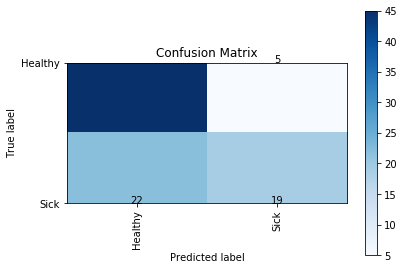

In [26]:
draw_confusion_matrix(y_true, y_pred, target_names)

### Question 3.1.3 Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

**Accuracy** 
- Accuracy measures the number of instances that are correctly classified by the classifier
- Accuracy = (True Positive + True Negative)/(True Positive + True Negative + False Positive + False Negative)

**Precision**
- Precision measures the number of instances the model classify as positive are True Positive.
- This might be desired over other metrics when accurately predicting if a person has a heart disease is more important than falsely predicting them having a heart disease. It might be because avoiding death of having a heart disease is preferred over worrying over an illness that they don't have.
- Precision = (True Positive)/(True Positive + False Positive)

**Recall**
- Recall measures how accurate the model classify the instances, that is, how many of the Predicted Instances are True instances.
- Considering all the people with heart disease, *recall* tells you how much it can classify them as positive with heart disease.
- Recall = (True Positive)/(True Positive + False Negative)

**F-1 Score**
- To take into account both *precision* and *recall*, we use F-1 Score.
- F-1 Score is generally used to evaluate how accurate a model is in the big picture.
- F-1 Score = (2 x Precision x Recall)/(Precision + Recall)



### Question 3.1.4 Plot a Receiver Operating Characteristic curve, or ROC curve, and describe what it is and what the results indicate

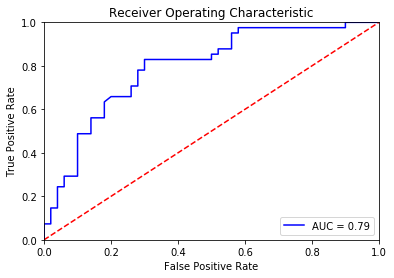

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class

probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Describe what an ROC Curve is and what the results mean here] 

### Question 3.1.5 Rerun, using the exact same settings, only this time use your processed data as inputs. 

In [28]:
clf_processed = SVC(probability=True)
clf_processed.fit(X_train_processed, y_train_processed)
y_pred_processed=clf_processed.predict(X_test_processed)
y_pred_processed

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0])

### Question 3.1.6 Report the accuracy, precision, recall, F1 Score, confusion matrix, and plot the ROC Curve of the resulting model.

In [29]:
y_true_processed = y_test_processed
print(classification_report(y_true_processed, y_pred_processed, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.82      0.84      0.83        50
        Sick       0.80      0.78      0.79        41

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



In [30]:
confusion_matrix(y_true_processed, y_pred_processed)

array([[42,  8],
       [ 9, 32]])

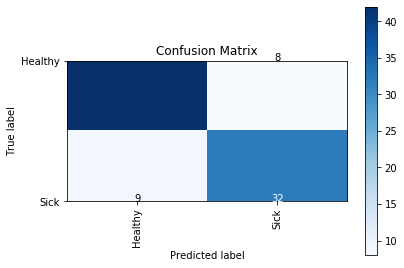

In [31]:
draw_confusion_matrix(y_true_processed, y_pred_processed, target_names)

### Question 3.1.7 Hopefully you've noticed a dramatic change in performance. Discuss why you think your new data has had such a dramatic impact. 

The reason why my new data has had such a dramatic impact is because both the train data and the test data has been processed. What we did for the processing is really important because it will change the effectiveness of our model. For this particular model, we ran our data through a pipeline which use `StandardScalar` to scale our numerical data to a more appropriate range. The reason for this is because we are predicting 0 and 1 so if the range of our value is anything above, arbitrarily speaking, 50 then our prediction won't be as accurate. 

### Question 3.1.8 Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

In [32]:
# SVM
clf_linear = SVC(kernel='linear', probability=True, random_state=42)
clf_linear.fit(X_train_processed, y_train_processed)
y_pred_linear=clf_linear.predict(X_test_processed)
y_pred_linear

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0])

In [33]:
y_true_linear = y_test_processed
print(classification_report(y_true_linear, y_pred_linear, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.82      0.84      0.83        50
        Sick       0.80      0.78      0.79        41

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



### Question 3.1.9 Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

After rerunning the data, there seems to be almost no change at all.

### Logistic Regression

Knowing that we're dealing with a linearly configured dataset, let's now try another classifier that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Question 3.2.1 Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. For this initial model set the solver = 'sag' and max_iter= 10). Report on the same four metrics as the SVM and graph the resulting ROC curve.

In [34]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_logistic_regression = LogisticRegression(solver='sag', max_iter=10).fit(X_train, y_train)
y_pred_logistic_regression = clf_logistic_regression.predict(X_test)
y_pred_logistic_regression

/Users/sondang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1])

In [35]:
y_true_logistic_regression = y_test
print(classification_report(y_true_logistic_regression, y_pred_logistic_regression, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.77      0.86      0.81        50
        Sick       0.80      0.68      0.74        41

    accuracy                           0.78        91
   macro avg       0.78      0.77      0.77        91
weighted avg       0.78      0.78      0.78        91



### Question 3.2.2 Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

In [36]:
clf_logistic_regression = LogisticRegression(solver='sag', max_iter=10000).fit(X_train, y_train)
y_pred_logistic_regression = clf_logistic_regression.predict(X_test)
y_pred_logistic_regression

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0])

In [37]:
y_true_logistic_regression = y_test
print(classification_report(y_true_logistic_regression, y_pred_logistic_regression, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.86      0.86      0.86        50
        Sick       0.83      0.83      0.83        41

    accuracy                           0.85        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.85      0.85      0.85        91



### Question 3.2.3 Explain what you changed, and why that produced an improved outcome. 

The warning was given because the `max_iter` was too small and our model did not converge, That is why we had the warning. By increasing `max_iter` to `10000` from `50` our model converges which gives us a better result and got rid of the warning.

### Question 3.2.4 Rerun your logistic classifier, but modify the penalty = 'none', solver='sag' and again report the results.

In [38]:
# Logistic Regression
clf_logistic_regression = LogisticRegression(solver='sag', max_iter=10000, penalty='none').fit(X_train, y_train)
y_pred_logistic_regression = clf_logistic_regression.predict(X_test)
y_pred_logistic_regression

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0])

### Question 3.2.5 Explain what what the penalty parameter is doing in this function, what the solver method is, and why this combination likely produced a more optimal outcome. 

- The penalty parameter is used to specify the norm used in the penalization. 
- Solver method is the algorithm we choose to use in the optimization problem.
- When we use this combination, we specify that we are not going to apply any regulation.

### Question 3.2.6 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

- Logistic regression adapts linear regression so that it estimates the probability a new instance falls in a class. The linear decision boundary is simply a consequence of the structure of the reression function and the use of a threshold in the function to classify
- SVM tries to place a linear boundary in a smart way. That's why the decision boundary is much more important to SVM than Logistic Regression.

### Clustering Approaches 

Let us now try a different approach to classification using a clustering algorithm. Specifically, we're going to be using K-Nearest Neighbor, one of the most popular clustering approaches. 

### K-Nearest Neighbor  

### Question 3.3.1 Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [39]:
# k-Nearest Neighbors algorithm
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier().fit(X_train_processed, y_train_processed)
y_pred_neigh = neigh.predict(X_test_processed)
y_pred_neigh

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0])

In [40]:
y_true_neigh = y_test
print(classification_report(y_true_neigh, y_pred_neigh, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.88      0.90      0.89        50
        Sick       0.88      0.85      0.86        41

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91



### Question 3.3.2 For clustering algorithms, we use different measures to determine the effectiveness of the model. Specifically here, we're interested in the Homogeneity Score, Completeness Score, V-Measure, Adjusted Rand Score, and Adjusted Mutual Information. Calculate each score (hint review the SKlearn Metrics Clustering documentation for how to implement).

In [41]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print("Homogeneity Score:", homogeneity_score(y_true_neigh, y_pred_neigh))
print("Completeness Score:", completeness_score(y_true_neigh, y_pred_neigh))
print("V-Measure Score:", v_measure_score(y_true_neigh, y_pred_neigh))
print("Adjusted Rand Score:", adjusted_rand_score(y_true_neigh, y_pred_neigh))
print("Adjusted Mutual Information Score:", adjusted_mutual_info_score(y_true_neigh, y_pred_neigh))

Homogeneity Score: 0.464422511329455
Completeness Score: 0.4660647012624859
V-Measure Score: 0.46524215716924433
Adjusted Rand Score: 0.5702094924593448
Adjusted Mutual Information Score: 0.4608553409931873


### Question 3.3.3 Explain what each score means and interpret the results for this particular model. 

- **Homogeneity Score** is used to check whether the clustering algorithm meets an important requirement, that is, a cluster should contain only samples belonging to a single class.
- **Completeness Score** is complementary to the Homogeneity Score. It determines the accuracy of how the clustering algorithm assigns all samples with the same true label to the same cluster.
- **V-Measure Score** is the harmonic mean between Homogeneity Score and Completeness Score
- **Adjusted Rand Score** is used to measure the similarity of datapoints presents in the cluster. In other words, it measures how similar the instances that are present in the cluster.
- **Adjusted Mutual Information Score** is similar to Adjusted Rand Score. However, Adjusted Rand Score is used when the ground truth clustering has large equal size clusters whereas Adjusted Mutual Information Score is used when the ground truth clustering is unbalanced and there exists small clusters

As we're beginning to see, the input parameters for your model can dramatically impact the performance of the model. How do you know which settings to choose? Studying the models and studying your datasets are critical as they can help you anticipate which models and settings are likely to produce optimal results. However sometimes that isn't enough, and a brute force method is necessary to determine which parameters to use. For this next question we'll attempt to optimize a parameter using a brute force approach. 

### Question 3.3.4 Parameter Optimization.  The KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 10, 20, 50, and 100. Run your model for each value and report the 6 measures (5 clustering specific plus accuracy) for each. Report on which n value produces the best accuracy and V-Measure. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [42]:
from sklearn.metrics import accuracy_score
n_neighbor_nums = [1, 2, 3, 5, 10, 20, 50, 100]
for i in n_neighbor_nums:
    neigh = KNeighborsClassifier(n_neighbors=i).fit(X_train_processed, y_train_processed)
    y_pred_neigh = neigh.predict(X_test_processed)
    print(i, "Nearest Neighbor")
    print("Homogeneity Score:", homogeneity_score(y_true_neigh, y_pred_neigh))
    print("Completeness Score:", completeness_score(y_true_neigh, y_pred_neigh))
    print("V-Measure Score:", v_measure_score(y_true_neigh, y_pred_neigh))
    print("Adjusted Rand Score:", adjusted_rand_score(y_true_neigh, y_pred_neigh))
    print("Adjusted Mutual Information Score:", adjusted_mutual_info_score(y_true_neigh, y_pred_neigh))
    print("Accuracy:", accuracy_score(y_true_neigh, y_pred_neigh))
    print()

1 Nearest Neighbor
Homogeneity Score: 0.23520891593749574
Completeness Score: 0.23704825531296908
V-Measure Score: 0.23612500371102957
Adjusted Rand Score: 0.3064793711335411
Adjusted Mutual Information Score: 0.22984431874178174
Accuracy: 0.7802197802197802

2 Nearest Neighbor
Homogeneity Score: 0.2686438402416599
Completeness Score: 0.2916557945375571
V-Measure Score: 0.27967725770221447
Adjusted Rand Score: 0.33195477962220943
Adjusted Mutual Information Score: 0.27351707383829005
Accuracy: 0.7912087912087912

3 Nearest Neighbor
Homogeneity Score: 0.3813910135012254
Completeness Score: 0.37952249690790807
V-Measure Score: 0.3804544610185576
Adjusted Rand Score: 0.4734990929615967
Adjusted Mutual Information Score: 0.3753951159073951
Accuracy: 0.8461538461538461

5 Nearest Neighbor
Homogeneity Score: 0.464422511329455
Completeness Score: 0.4660647012624859
V-Measure Score: 0.46524215716924433
Adjusted Rand Score: 0.5702094924593448
Adjusted Mutual Information Score: 0.460855340993187

The optimal result is when we use 5 Nearest neighbor which gives us both highest *Accuracy* and *V-Measure Score*.

### Question 3.3.5 When are clustering algorithms most effective, and what do you think  explains the comparative results we achieved?  

It is most effective to use clustering algorithms when our dataset has a smaller number of dimensions because when there are too many dimensions, it will become harder to cluster instances together to make any sense out of it. The model will be too complicated and too spread out the more dimensions there are.